In [1]:
#!pip install sidetable
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
#import sidetable
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder


Required libraries are imported

Dataframe is created

In [6]:
# read an example file - 2020/10/01
df = pd.read_csv('/kaggle/input/luflow-network-intrusion-detection-data-set/2022/06/2022.06.14/2022.06.14.csv')
# first glance
df.head()

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,500.000000,14280,630,786,44010.0,2.289381,30,60,6,786,9300.0,1655205565122718,1655205535093364,34134.6700,benign,30.029354
1,8.500000,329,5559,786,9200.0,4.158200,2,2,6,786,52136.0,1655205555212462,1655205555194823,24483.4800,benign,0.017639
2,30.350000,24575,27280,786,9300.0,1.766307,129,117,6,786,52928.0,1655205557003075,1655205553761954,91591.8400,benign,3.241121
3,59.000000,89,183,786,445.0,3.611253,6,6,6,786,19237.0,1655193703166392,1655193702919862,982.2609,outlier,0.246530
4,106.857143,34,29,786,5900.0,5.139898,11,10,6,786,47008.0,1655193704975769,1655193703987056,323.8136,outlier,0.988713


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590086 entries, 0 to 590085
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   avg_ipt        590086 non-null  float64
 1   bytes_in       590086 non-null  int64  
 2   bytes_out      590086 non-null  int64  
 3   dest_ip        590086 non-null  int64  
 4   dest_port      541616 non-null  float64
 5   entropy        590086 non-null  float64
 6   num_pkts_out   590086 non-null  int64  
 7   num_pkts_in    590086 non-null  int64  
 8   proto          590086 non-null  int64  
 9   src_ip         590086 non-null  int64  
 10  src_port       541616 non-null  float64
 11  time_end       590086 non-null  int64  
 12  time_start     590086 non-null  int64  
 13  total_entropy  590086 non-null  float64
 14  label          590086 non-null  object 
 15  duration       590086 non-null  float64
dtypes: float64(6), int64(9), object(1)
memory usage: 72.0+ MB


On inspection of dataframe we can see that there are 16 columns and 590085 rows. We can see that 

In [7]:
df.isna().sum()

avg_ipt              0
bytes_in             0
bytes_out            0
dest_ip              0
dest_port        48470
entropy              0
num_pkts_out         0
num_pkts_in          0
proto                0
src_ip               0
src_port         48470
time_end             0
time_start           0
total_entropy        0
label                0
duration             0
dtype: int64

Check the empty values, and remove those rows.

<AxesSubplot:>

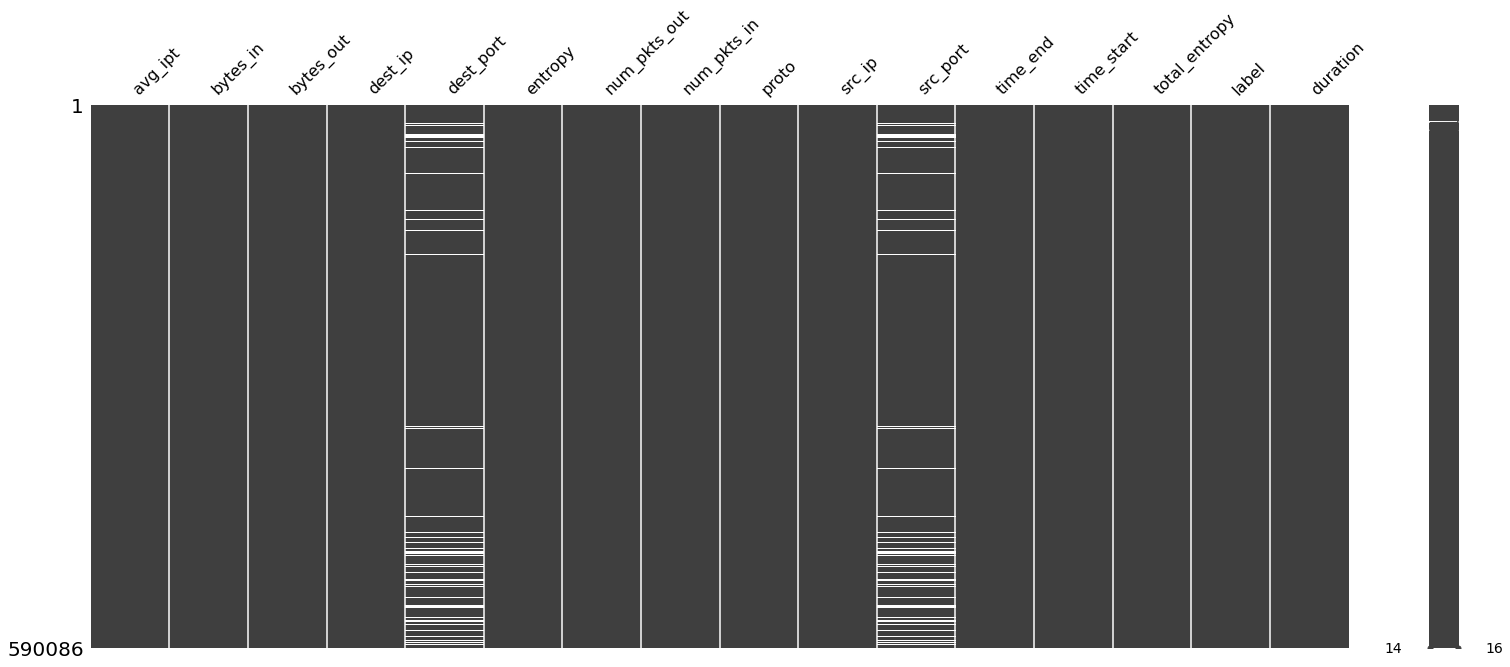

In [8]:
import missingno as msno
%matplotlib inline
msno.matrix(df)

In [9]:
df.dropna(axis=0,inplace=True,how="any")

In [10]:
df.nunique()

avg_ipt           32259
bytes_in          15057
bytes_out         32588
dest_ip               1
dest_port         19631
entropy          247507
num_pkts_out        256
num_pkts_in         256
proto                 2
src_ip                1
src_port          49535
time_end         539498
time_start       539423
total_entropy    257485
label                 2
duration         208116
dtype: int64

Each attribute is checked for unique values. We remove columns "time_end" and "time_start" as they have high variability (see number of unique values). We will also remove "src_ip" and "dest_ip" as they have alwyws the same value for all rows.

In [11]:
df.count()

avg_ipt          541616
bytes_in         541616
bytes_out        541616
dest_ip          541616
dest_port        541616
entropy          541616
num_pkts_out     541616
num_pkts_in      541616
proto            541616
src_ip           541616
src_port         541616
time_end         541616
time_start       541616
total_entropy    541616
label            541616
duration         541616
dtype: int64

In [12]:
df.drop(["src_ip","dest_ip","time_end","time_start"],axis=1,inplace=True)

In [13]:
df.count()

avg_ipt          541616
bytes_in         541616
bytes_out        541616
dest_port        541616
entropy          541616
num_pkts_out     541616
num_pkts_in      541616
proto            541616
src_port         541616
total_entropy    541616
label            541616
duration         541616
dtype: int64

In [14]:
df.corr()

,avg_ipt,bytes_in,bytes_out,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_port,total_entropy,duration
avg_ipt,1.000000,0.001130,0.000313,-0.015749,0.058660,-0.005764,-0.004609,-0.004222,0.035789,0.011618,0.008536
bytes_in,0.001130,1.000000,0.365630,0.131285,0.001028,0.610159,0.749201,-0.016270,-0.068149,0.683840,0.580959
bytes_out,0.000313,0.365630,1.000000,-0.126162,-0.149538,0.586975,0.446214,-0.036068,0.272401,0.661976,0.621210
dest_port,-0.015749,0.131285,-0.126162,1.000000,-0.127426,-0.074473,-0.047240,-0.060062,-0.613486,-0.047464,-0.039029
entropy,0.058660,0.001028,-0.149538,-0.127426,1.000000,0.027419,0.088011,0.024852,0.138843,0.079086,-0.022205
num_pkts_out,-0.005764,0.610159,0.586975,-0.074473,0.027419,1.000000,0.774294,-0.026623,0.094590,0.675970,0.792899
num_pkts_in,-0.004609,0.749201,0.446214,-0.047240,0.088011,0.774294,1.000000,-0.024923,0.023823,0.686524,0.751938
proto,-0.004222,-0.016270,-0.036068,-0.060062,0.024852,-0.026623,-0.024923,1.000000,-0.102089,-0.031981,-0.008546
src_port,0.035789,-0.068149,0.272401,-0.613486,0.138843,0.094590,0.023823,-0.102089,1.000000,0.166579,0.079831
total_entropy,0.011618,0.683840,0.661976,-0.047464,0.079086,0.675970,0.686524,-0.031981,0.166579,1.000000,0.633592


Correlation is found between each attribute.

<AxesSubplot:>

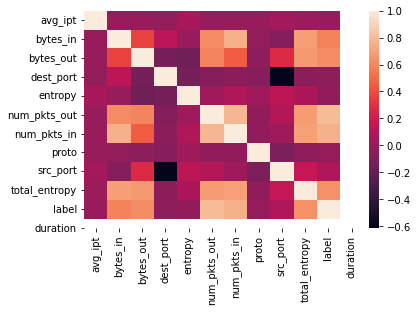

In [15]:
sns.heatmap(df.corr(),
            xticklabels=df.columns,
            yticklabels=df.columns
           )

Feature set and Target values are set

In [21]:
x = df.drop(['label',], axis=1)
y=df['label']

In [22]:
df.shape

(541616, 12)

There are 12 attributes with 541,616 rows.

Data modelling starts:
We first use KNN model with n=30, and 9 iterations.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
n_neighbors=30
scores=[]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=30)
for k in range(1,10):
    knn=KNeighborsClassifier(n_neighbors-k)
    knn.fit(x_train,y_train)
    y_pred=knn.predict(x_test)
    print('Accuracy=',accuracy_score(y_pred,y_test))
    

Accuracy= 0.9976921088586094
Accuracy= 0.9976644141649127
Accuracy= 0.9977290351168716
Accuracy= 0.9977474982460027
Accuracy= 0.9978028876333961
Accuracy= 0.9977382666814372
Accuracy= 0.9977936560688305
Accuracy= 0.9977936560688305
Accuracy= 0.9978213507625272


In [ ]:
import time
start_time = time.time()
knn.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

start_time = time.time()
y_test_pred = knn.predict(x_test)
end_time = time.time()
print("Testing time: ",end_time-start_time)

Now we use this model to train and test normalised data

In [34]:
df_metrics=df.loc[:, df.columns != 'label']
#We will scale all metrics' data between 0 and 1

from sklearn.preprocessing import MinMaxScaler

values = df_metrics.values

scaler = MinMaxScaler(feature_range=(0, 1))

scaledData = scaler.fit_transform(values)


In [35]:
from pandas import DataFrame

df_scaled= DataFrame(scaledData)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.164153e-07,0.218072,0.009613,0.671555,0.017054,0.117647,0.235294,0.0,0.141715,0.008578,0.752972
1,1.979060e-09,0.005024,0.084825,0.140300,0.030976,0.007843,0.007843,0.0,0.795510,0.006153,0.000442
2,7.066410e-09,0.375288,0.416266,0.141826,0.013158,0.505882,0.458824,0.0,0.807598,0.023018,0.081270
3,1.373701e-08,0.001359,0.002792,0.006685,0.026902,0.023529,0.023529,0.0,0.293381,0.000247,0.006182
4,2.487962e-08,0.000519,0.000443,0.089937,0.038289,0.043137,0.039216,0.0,0.717242,0.000081,0.024792


In [36]:
x_scaled=df_scaled
y=df['label']

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
n_neighbors=30
scores=[]
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=30)
for k in range(1,10):
    knn=KNeighborsClassifier(n_neighbors-k)
    knn.fit(x_train,y_train)
    y_pred=knn.predict(x_test)
    print('Accuracy=',accuracy_score(y_pred,y_test))

Accuracy= 0.9979044348436173
Accuracy= 0.9978767401499206
Accuracy= 0.997932129537314
Accuracy= 0.9979413611018796
Accuracy= 0.9980152136184041
Accuracy= 0.9980429083121007
Accuracy= 0.9981167608286252
Accuracy= 0.9981075292640597
Accuracy= 0.9981259923931908


In [47]:
from sklearn.naive_bayes import GaussianNB
model1 = GaussianNB()
model1.fit(x_train, y_train.values.ravel())

GaussianNB()

In [ ]:
y_pred1 = model1.predict(x_test)
print("Training Model score=", model1.score(x_train,y_train))
print("Testing Model score=", model1.score(x_test,y_test))
print('Accuracy Score=', accuracy_score(y_pred1,y_test))



In [54]:
print(y)

0          benign
1          benign
2          benign
3         outlier
4         outlier
           ...   
590074     benign
590077    outlier
590079     benign
590083    outlier
590084    outlier
Name: label, Length: 541616, dtype: object


In [55]:
print(y_test)

370699     benign
422138    outlier
468251     benign
261434    outlier
395941     benign
           ...   
566277    outlier
342484     benign
59537     outlier
80338      benign
198481     benign
Name: label, Length: 108324, dtype: object


The next model we use is Decision Tree Model

In [56]:
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
model2.fit(x_train, y_train.values.ravel())




DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [57]:
y_test_pred2 = model2.predict(x_test)

In [58]:
print("Train score is:", model2.score(x_train, y_train))
print("Test score is:",model2.score(x_test,y_test))

Train score is: 0.9956057347008483
Test score is: 0.995504228056571


In [59]:
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier(n_estimators=30)
model3.fit(x_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=30)

In [60]:
y_test_pred3 = model3.predict(x_test)

In [61]:
print(y_test_pred3)

['benign' 'outlier' 'benign' ... 'outlier' 'benign' 'benign']


In [62]:
print("Train score is:", model3.score(x_train, y_train))
print("Test score is:",model3.score(x_test,y_test))

Train score is: 0.9998984518523305
Test score is: 0.9997692108858609


In [64]:
x_test["y_values"] = y_test.tolist()
x_test["predictions_vals"] = y_test_pred3.tolist()
x_test.head(20)

,0,1,2,3,4,5,6,7,8,9,10,y_values,predictions_vals
354108,0.000000e+00,0.000000,0.006394,0.720606,0.053264,0.027451,0.000000,0.0,0.140188,0.000753,0.000300,benign,benign
403981,8.614734e-09,0.000183,0.000000,0.089937,0.021739,0.003922,0.003922,0.0,0.692822,0.000009,0.000952,outlier,outlier
445669,0.000000e+00,0.000000,0.000000,0.141826,0.000000,0.003922,0.000000,0.0,0.698713,0.000000,0.000000,benign,benign
246794,0.000000e+00,0.000000,0.000000,0.000244,0.000000,0.003922,0.003922,0.0,0.788092,0.000000,0.000014,outlier,outlier
378204,3.259629e-10,0.005620,0.068956,0.140300,0.037470,0.015686,0.007843,0.0,0.720661,0.006178,0.000001,benign,benign
198544,0.000000e+00,0.000000,0.122789,0.140300,0.025321,0.023529,0.015686,0.0,0.720600,0.006874,0.000008,benign,benign
190763,0.000000e+00,0.000000,0.074037,0.140300,0.031609,0.015686,0.011765,0.0,0.720692,0.005174,0.000011,benign,benign
535169,1.350418e-09,0.005024,0.273701,0.140300,0.012909,0.019608,0.011765,0.0,0.796487,0.007954,0.000743,benign,benign
471932,2.221870e-08,0.000519,0.000443,0.089937,0.038289,0.043137,0.039216,0.0,0.189609,0.000081,0.023127,outlier,outlier
133784,0.000000e+00,0.154788,0.000000,0.720637,0.018097,0.011765,0.027451,0.0,0.140188,0.006188,0.000006,benign,benign


In [ ]:
from sklearn.svm import SVC
model4 = SVC(gamma = 'scale')
model4.fit(x_train, y_train.values.ravel())

In [ ]:
y_test_pred4 = model4.predict(x_test)

In [ ]:
print("Train score is:", model4.score(x_train, y_train))
print("Test score is:", model4.score(x_test,y_test))

In [ ]:
from sklearn.linear_model import LogisticRegression
model5 = LogisticRegression(max_iter=1200000)
model5.fit(x_train, y_train.values.ravel())

In [ ]:
y_test_pred5 = model5.predict(x_test)

In [ ]:
print("Train score is:", model5.score(x_train, y_train))
print("Test score is:",model5.score(x_test,y_test))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def fun():
    model = Sequential()
    
    #here 30 is output dimension
    model.add(Dense(30,input_dim =30,activation = 'relu',kernel_initializer='random_uniform'))
    
    #in next layer we do not specify the input_dim as the model is sequential so output of previous layer is input to next layer
    model.add(Dense(1,activation='sigmoid',kernel_initializer='random_uniform'))
    
    #5 classes-normal,dos,probe,r2l,u2r
    model.add(Dense(5,activation='softmax'))
    
    #loss is categorical_crossentropy which specifies that we have multiple classes
    
    model.compile(loss ='categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    return model

In [ ]:
model7 = KerasClassifier(build_fn=fun,epochs=100,batch_size=64)

In [ ]:
model7.fit(x_train, y_train.values.ravel())

In [ ]:
y_test_pred7 = model7.predict(x_test)

In [ ]:
y_train_pred7 = model7.predict(x_train)

In [ ]:
print("train accuracy=",accuracy_score(y_train,y_train_pred7))
print("test accuracy=",accuracy_score(y_test,y_test_pred7))
